In [1]:
import sys
sys.path.append('../utils')
from nd_tools import scale_img

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

In [2]:
data_dir = Path('../data')
backscatter_tifs = sorted(list(data_dir.glob('./*backscatter*.tif')))
backscatter_tifs

[PosixPath('../data/alos_backscatter_hh.tif'),
 PosixPath('../data/alos_backscatter_hv.tif')]

In [3]:
data_dir = Path('../data')
tv_tifs = sorted(list(data_dir.glob('./*tv.tif')))
tv_tifs

[PosixPath('../data/alos_hh_tv.tif'), PosixPath('../data/alos_hv_tv.tif')]

In [4]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one, backscatter_tifs))
eps = .00001
bands += [bands[0] / (bands[1] + eps)]

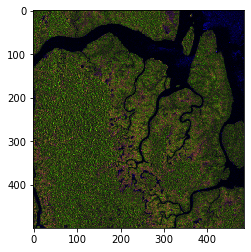

In [5]:
bands = list(map(scale_img, bands))
rgb = np.stack(bands, axis=2)
plt.imshow(rgb)

## TV Denoised RGB

Use the TV Denoised Images to create an RGB image as before.

In [6]:
bands_tv = list(map(open_one, tv_tifs))
eps = .00001
bands_tv += [bands_tv[0] / (bands_tv[1] + eps)]

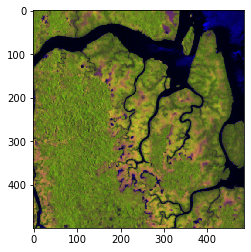

In [7]:
temp = list(map(scale_img, bands_tv))
rgb_tv = np.stack(temp, axis=2)
plt.imshow(rgb_tv)

In [8]:
with rasterio.open(tv_tifs[0]) as ds:
    profile = ds.profile
profile['count'] = 3
with rasterio.open(data_dir/'rgb.tif', 'w', **profile) as ds:
    ds.write(np.moveaxis(rgb_tv, 2, 0))

# Exercise 2

Inspect the RGB Image from decibels. How does k-means run on this?

In [9]:
def open_one_db(path):
    with rasterio.open(path) as ds:
        band = 10 * np.log10(ds.read(1))
    return band

bands_db = list(map(open_one_db, tv_tifs))
eps = .00001
bands_db += [bands_db[0] / (bands_db[1] + eps)]

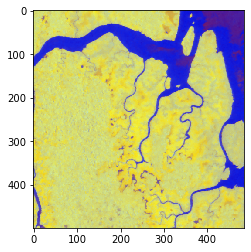

In [10]:
temp = list(map(scale_img, bands_db))
rgb_tv_db = np.stack(temp, axis=2)
plt.imshow(rgb_tv_db)

In [11]:
## Answer
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, 
               random_state=0)
X_train = np.zeros((rgb_tv[..., 0].size, 3))
for k in range(2):
    X_train[:, k] = bands_db[k].ravel()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

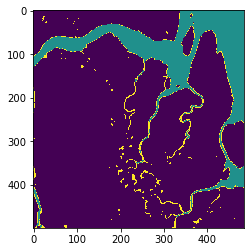

In [12]:
## Answer

classes = model.labels_.reshape(bands_db[0].shape)
plt.imshow(classes)

# Acknowledgements

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.